In [1]:
import argparse
import numpy as np
import healpy as hp
from mnms import utils as mutils
from sofind import DataModel
from solenspipe.utility import w_n
from pixell import curvedsky as cs, reproject, enmap
from orphics import maps
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import rcParams

rcParams['font.size']=25
rcParams['axes.linewidth']=1.5
rcParams['xtick.major.width']=1.5
rcParams['xtick.minor.width']=1
rcParams['ytick.major.width']=1.5
rcParams['ytick.minor.width']=1
rcParams['xtick.major.pad']='8'
rcParams['xtick.direction'] = 'in'
rcParams['xtick.top'] = True
rcParams['ytick.direction'] = 'in'
rcParams['xtick.minor.visible'] = True
rcParams['ytick.minor.visible'] = True
rcParams['ytick.right'] = True
rcParams['text.usetex'] = True
rcParams['font.family'] = 'Helvetica'

--------------------------------------------------------------------------

  Local host:   login-q-3
  Local device: mlx5_0
--------------------------------------------------------------------------


In [2]:
FSKYS = ['GAL060', 'GAL070', 'GAL080']

In [4]:
args = argparse.Namespace()

args.config_name='act_dr6v4'
args.mask_subproduct='lensing_masks'
args.mask_type='dr6v4_lensing_20240919'
args.daynight='night'
args.mlmax=4000
args.skyfrac='GAL060'

dm = DataModel.from_config(args.config_name)

## ACT masks

In [5]:
masks_pixell = {}
w2_pixell = {}
w_pixell = {}
for fsky in FSKYS:
    
    masks_pixell[fsky] = enmap.read_map(f'/rds/project/dirac_vol5/rds-dirac-dp002/AdvACT/DR6_products/masks/{args.mask_type}_{args.daynight}_enhanced_mask_{fsky.split("GAL0")[1]}_d2_apo3deg.fits') 

    # w2 and w (fsky) factors
    w2_pixell[fsky] = w_n(masks_pixell[fsky],2)
    w_pixell[fsky] = w_n(masks_pixell[fsky],1)

args.shape, args.wcs = masks_pixell[args.skyfrac].shape, masks_pixell[args.skyfrac].wcs

In [6]:
# print fskys
for i in w_pixell.keys():
    print(i, f'{w_pixell[i]:.6f}')

GAL060 0.283353
GAL070 0.311745
GAL080 0.342116


### load Planck dust map for background

In [7]:
p353 = hp.read_map('/rds/project/dirac_vol5/rds-dirac-dp002/ia404/fgs/Planck/COM_CompMap_IQU-thermaldust-gnilc-unires_2048_R3.00.fits')
p353_car = reproject.healpix2map(p353, masks_pixell[args.skyfrac].shape, masks_pixell[args.skyfrac].wcs, lmax = args.mlmax, rot="gal,cel")

In [8]:
toplot_act = (p353_car * masks_pixell['GAL080']).downgrade(8) # we plot downgraded version
masked_toplot_act = np.ma.masked_where(toplot_act == 0, toplot_act) # mask for zero (outside mask) values

/home/ia404/.conda/envs/dr6plus_ice1/lib/python3.8/site-packages/matplotlib/ticker.py:2865: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/home/ia404/.conda/envs/dr6plus_ice1/lib/python3.8/site-packages/matplotlib/ticker.py:2865: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/home/ia404/.conda/envs/dr6plus_ice1/lib/python3.8/site-packages/matplotlib/ticker.py:2865: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


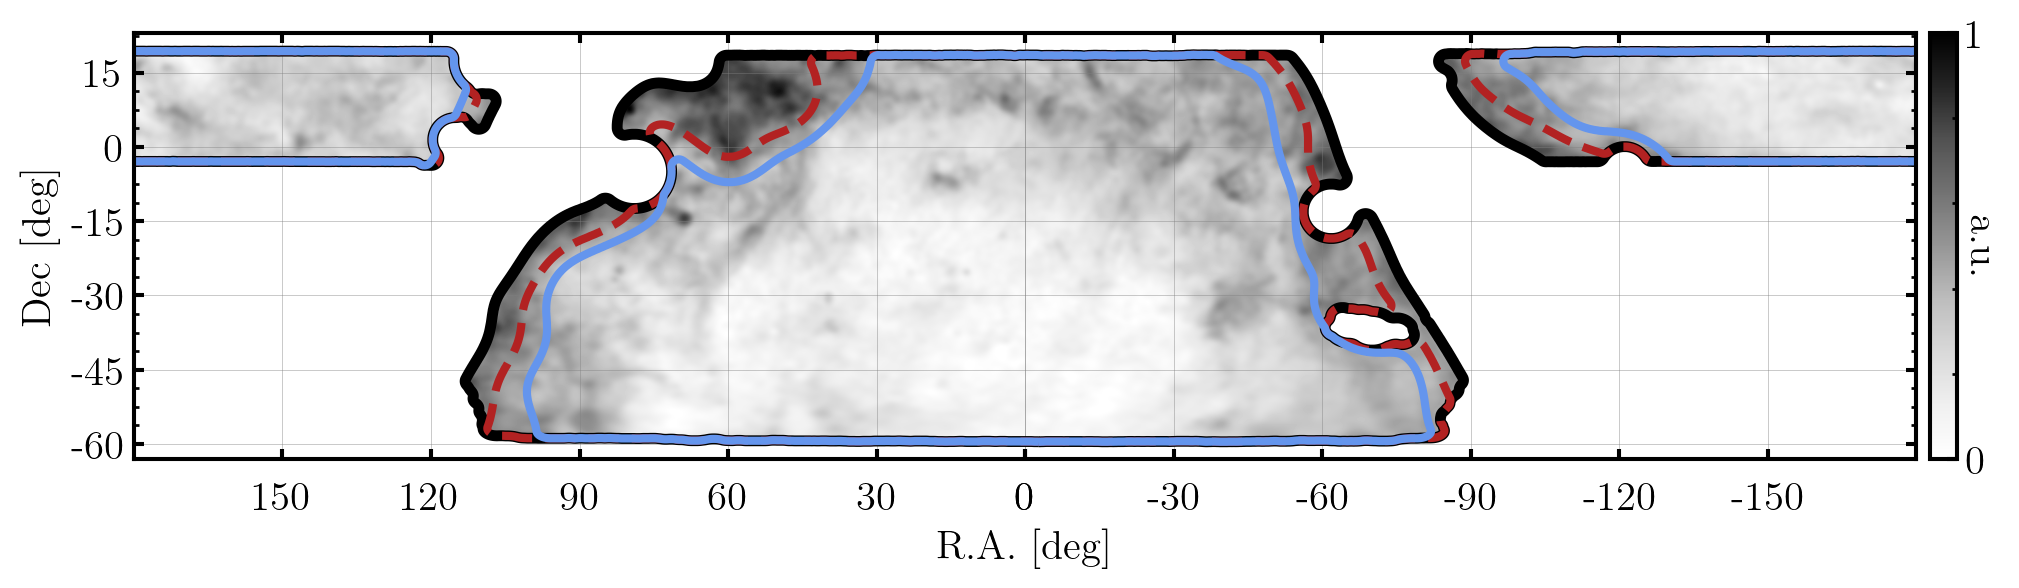

In [9]:
fig, ax = plt.subplots(figsize=(12, 3), dpi=196, squeeze=True)

mutils.plot(masks_pixell['GAL080'], ax=ax, cmap='Greys',  alpha=1, downgrade=8, ticks=(15, 30), mask=0, min=0, max=1, \
            colorbar=True, grid=True, colorbar_label='a.u.', xlabel='R.A. [deg]', ylabel='Dec [deg]',
           colorbar_labelpad=5, colorbar_fontsize=15, label_fontsize=15, tick_fontsize=15)

ax.imshow((masked_toplot_act), origin='lower', cmap='binary', norm=mcolors.LogNorm(vmin=5e-4,vmax=masked_toplot_act.max()))

ax.contour(masks_pixell['GAL080'].downgrade(8), levels=[0.5], colors='black', origin='lower', linewidths=4)
ax.contour(masks_pixell['GAL070'].downgrade(8), levels=[0.5], colors='firebrick', origin='lower', linewidths=3, linestyles='dashed')
ax.contour(masks_pixell['GAL060'].downgrade(8), levels=[0.5], colors='cornflowerblue', origin='lower', linewidths=3.)

plt.show()

In [ ]:
enmap.write_map('/rds/project/dirac_vol5/rds-dirac-dp002/ia404/fgs/masks/ACT_GAL060_wcsACT_car_apo3deg.fits', masks_pixell['GAL060'])
enmap.write_map('/rds/project/dirac_vol5/rds-dirac-dp002/ia404/fgs/masks/ACT_GAL070_wcsACT_car_apo3deg.fits', masks_pixell['GAL070'])
enmap.write_map('/rds/project/dirac_vol5/rds-dirac-dp002/ia404/fgs/masks/ACT_GAL080_wcsACT_car_apo3deg.fits', masks_pixell['GAL080'])

## SO masks

In [10]:
# Redefine geometry, default ACT masks not big enough for SO

# Set the size of the box in degrees and convert to radians
dec_from, dec_to = np.deg2rad([-65,25])
ra_from, ra_to = np.deg2rad([180,-180])

# Create the box
box = [[dec_from,ra_from],[dec_to,ra_to]]

In [11]:
# 70% mask
solat_0 = hp.read_map('/rds/project/dirac_vol5/rds-dirac-dp002/ia404/fgs/masks/LAT_ivar_mask_galcoords.fits' ) 
# 80% mask
solat_1 = hp.read_map('/rds/project/dirac_vol5/rds-dirac-dp002/ia404/fgs/masks/Mask_fullLAT_5.0_deg_gal_with-srcs-galplane80.fits')

In [13]:
masks_pixell = enmap.read_map(f'/rds/project/dirac_vol5/rds-dirac-dp002/AdvACT/DR6_products/masks/{args.mask_type}_{args.daynight}_enhanced_mask_70_d2_apo3deg.fits', box=box) 

In [14]:
solat0_car = reproject.healpix2map(solat_0, masks_pixell.shape, masks_pixell.wcs, lmax = args.mlmax, rot="gal,cel")
solat1_car = reproject.healpix2map(solat_1, masks_pixell.shape, masks_pixell.wcs, lmax = args.mlmax, rot="gal,cel")

In [15]:
# the raw masks have holes in them and follow the scanning strategy with nhits
# i just need a simply bool mask so I start making cuts

## all these thresholds are arbitrary. chosen to roughly reproduce fsky numbers in SO papers

solat0_car[solat0_car<0.1] = 0
solat0_car[solat0_car>0.1] = 1
solat1_car[solat1_car<0.001] = 0
solat1_car[solat1_car>0.001] = 1

In [16]:
print(f'fsky 70% {w_n(solat0_car, 1):.2f}')
print(f'fsky 80% {w_n(solat1_car,1):.2f}')

fsky 70% 0.56
fsky 80% 0.52


In [17]:
solat0_car_apo = maps.cosine_apodize(solat0_car, 3)
solat1_car_apo = maps.cosine_apodize(solat1_car, 3)

In [18]:
print(f'fsky 70% {w_n(solat0_car_apo, 1):.4f}')
print(f'fsky 80% {w_n(solat1_car_apo,1):.4f}')

fsky 70% 0.4294
fsky 80% 0.4947


### load Planck dust map for background

In [20]:
p353 = hp.read_map('/rds/project/dirac_vol5/rds-dirac-dp002/ia404/fgs/Planck/COM_CompMap_IQU-thermaldust-gnilc-unires_2048_R3.00.fits')
p353_car = reproject.healpix2map(p353, masks_pixell.shape, masks_pixell.wcs, lmax = args.mlmax, rot="gal,cel")

In [21]:
toplot_so = (p353_car * solat1_car_apo).downgrade(8) # we plot downgraded version
masked_toplot_so = np.ma.masked_where(toplot_so == 0, toplot_so) # mask for zero (outside mask) values

/home/ia404/.conda/envs/dr6plus_ice1/lib/python3.8/site-packages/matplotlib/ticker.py:2865: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/home/ia404/.conda/envs/dr6plus_ice1/lib/python3.8/site-packages/matplotlib/ticker.py:2865: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


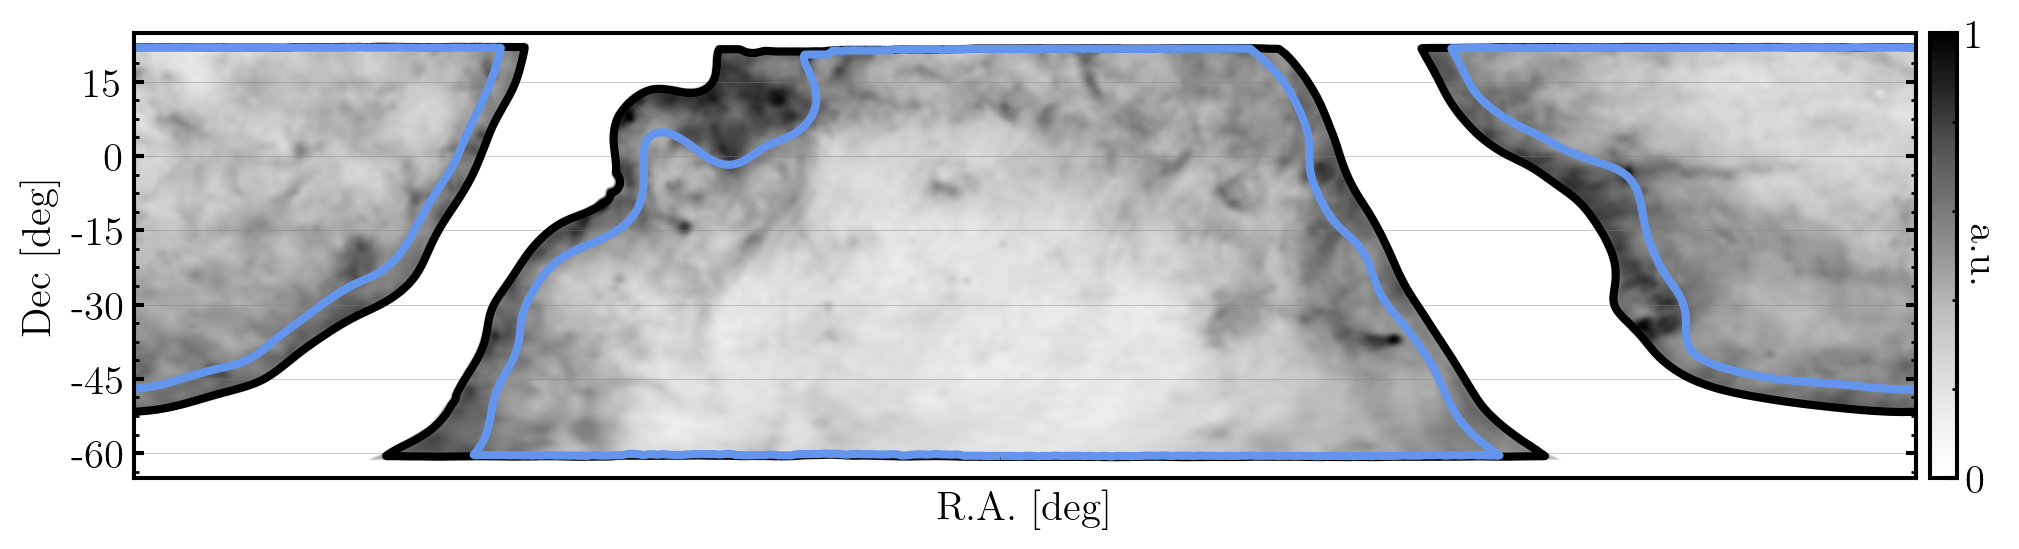

In [23]:
fig, ax = plt.subplots(figsize=(12, 3), dpi=196, squeeze=True)

mutils.plot(masks_pixell, ax=ax, cmap='Greys',  alpha=1, downgrade=8, ticks=(15, 30), mask=0, min=0, max=1, \
            colorbar=True, grid=True, colorbar_label='a.u.', xlabel='R.A. [deg]', ylabel='Dec [deg]',
           colorbar_labelpad=5, colorbar_fontsize=15, label_fontsize=15, tick_fontsize=15)

ax.imshow((masked_toplot_so), origin='lower', cmap='binary', norm=mcolors.LogNorm(vmin=4e-4,vmax=masked_toplot_so.max()*0.95))
ax.contour(solat1_car_apo.downgrade(8), levels=[0.5], colors='black', origin='lower', linewidths=3)
ax.contour(solat0_car_apo.downgrade(8), levels=[0.5], colors='cornflowerblue', origin='lower', linewidths=3)
plt.show()


In [ ]:
enmap.write_map('/rds/project/dirac_vol5/rds-dirac-dp002/ia404/fgs/masks/SOLAT_GAL070_wcsSO_car_apo3deg.fits', solat0_car_apo)
enmap.write_map('/rds/project/dirac_vol5/rds-dirac-dp002/ia404/fgs/masks/SOLAT_GAL080_wcsSO_car_apo3deg.fits', solat1_car_apo)